# Self-organized criticality

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell1D.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

In [3]:
from utils import decorate, savefig
# make a directory for figures
!mkdir -p figs

## Sand pile

Here's an implementation of the sand pile model.

In [4]:
import itertools
from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array

class SandPile(Cell2D):
    """Diffusion Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1,-4, 1],
                       [0, 1, 0]], dtype=np.int32)

    def __init__(self, n, m=None, level=9):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        level: starting value for all cells
        """
        m = n if m is None else m
        self.array = np.ones((n, m), dtype=np.int32) * level
        self.toppled_seq = []

    def step(self, K=3):
        """Executes one time step.
        
        returns: number of cells that toppled
        """
        toppling = self.array > K
        num_toppled = np.sum(toppling)
        self.toppled_seq.append(num_toppled)

        c = correlate2d(toppling, self.kernel, mode='same')
        self.array += c
        return num_toppled
    
    def drop(self):
        """Increments a random cell."""
        a = self.array
        n, m = a.shape
        index = np.random.randint(n), np.random.randint(m)
        a[index] += 1
    
    def run(self):
        """Runs until equilibrium.
        
        returns: duration, total number of topplings
        """
        total = 0
        for i in itertools.count(1):
            num_toppled = self.step()
            total += num_toppled
            if num_toppled == 0:
                return i, total

    def drop_and_run(self):
        """Drops a random grain and runs to equilibrium.
        
        returns: duration, total_toppled
        """
        self.drop()
        duration, total_toppled = self.run()
        return duration, total_toppled
    
    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='YlOrRd', vmax=5)

Here's a small example starting with two cells ready to topple.  `n` is the number of rows, `m` is the number of columns.

In [5]:
pile = SandPile(n=3, m=5, level=0)
pile.array[1, 1] = 4
pile.array[1, 3] = 4

a = pile.array
print(a)

[[0 0 0 0 0]
 [0 4 0 4 0]
 [0 0 0 0 0]]


To execute one step, first we find cells that are above the toppling threshold, `K`.

In [6]:
K = 3
toppling = a > K
print(toppling.astype(int))

[[0 0 0 0 0]
 [0 1 0 1 0]
 [0 0 0 0 0]]


Then we use `correlate2d` to make a copy of the update kernel around each toppling cell.

In [7]:
kernel = np.array([[0, 1, 0],
                   [1,-4, 1],
                   [0, 1, 0]])
print(kernel)

[[ 0  1  0]
 [ 1 -4  1]
 [ 0  1  0]]


In [8]:
from scipy.signal import correlate2d

c = correlate2d(toppling, kernel, mode='same', boundary='fill', fillvalue=0)
print(c)

[[ 0  1  0  1  0]
 [ 1 -4  2 -4  1]
 [ 0  1  0  1  0]]


Finally, we add the result back into the array:

In [9]:
a += c
print(a)

[[0 1 0 1 0]
 [1 0 2 0 1]
 [0 1 0 1 0]]


Any grains that topple off the edge disappear.

## Animation

Let's look at a bigger pile, with `n=20`.  All cells are initialized to `level`, which is meant to be substantially bigger than `K`.

In [10]:
pile = SandPile(n=20, level=10)
print(pile.run())

(332, 53336)


The `run` function invokes `step` until no more cells topple and returns the number of time steps and the number of affected cells.

Here's what it looks like.  Starting with `level>K` produces all kinds of interesting patterns.

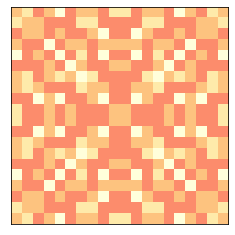

In [11]:
pile.draw()

Now let's look at an animation, starting from this initialized pile.

Each step of the animation drops a single grain at a random location and runs until no more cells topple.

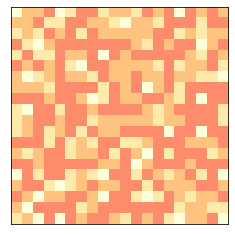

In [12]:
pile.animate(frames=100, step=pile.drop_and_run)

After a while, the pile looks pretty random.

Here's a plot of the number of cells toppled after each `step`.  

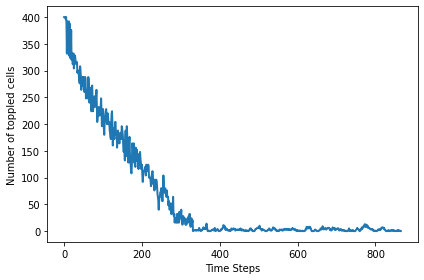

In [13]:
plt.plot(pile.toppled_seq)
decorate(xlabel='Time Steps', ylabel='Number of toppled cells')

The following figure shows the progression of the pile from ordered to apparently random.

(332, 53336)
Saving figure to file figs/chap08-1


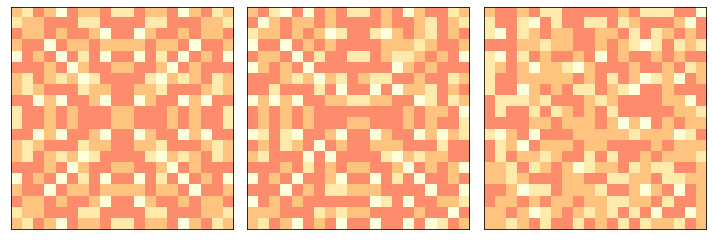

In [14]:
np.random.seed(17)

pile = SandPile(n=20, level=10)
print(pile.run())

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
pile.draw()

plt.subplot(1, 3, 2)
for i in range(20):
    pile.drop_and_run()
pile.draw()

plt.subplot(1, 3, 3)
for i in range(200):
    pile.drop_and_run()
pile.draw()

plt.tight_layout()
savefig('figs/chap08-1')

## Long tailed distributions

If the sand pile is in a critical state, we expect quantities like the duration of an avalanche, `T`, and the number of cells affected, `S`, to have long-tailed distributions.

Following Bak, Tang, and Wiesenseld, we start with a 50x50 array and plot the PMFs of `S` and `T` on a log-log scale.

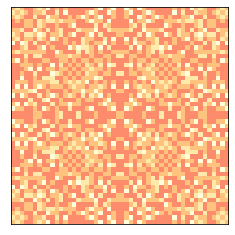

In [15]:
pile2 = SandPile(n=50, level=30)
pile2.run()
pile2.draw()

Now we run the pile for many time steps and keep track of the durations and number of cells affected.

In [16]:
np.random.seed(17)

iters = 100000
%time res = [pile2.drop_and_run() for _ in range(iters)]

CPU times: user 3min 37s, sys: 56.6 ms, total: 3min 37s
Wall time: 3min 37s


We can use `np.transpose` to extract the results as two NumPy arrays.

In [17]:
T, S = np.transpose(res)

A large majority of drops have duration 1 and no toppled cells.  If we filter them out, we get a clearer picture of the rest of the distribution.

In [18]:
T = T[T>1]
S = S[S>0]

We can use `Pmf` from the `empiricaldist` module to compute PMFs of `T` and `S`.

In [19]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [20]:
from empiricaldist import Pmf

pmfT = Pmf.from_seq(T)
pmfS = Pmf.from_seq(S)

The distributions of `T` and `S` have many small values and a few very large ones.

Here are the PMFs on linear axes (showing values up to 50).

Saving figure to file figs/chap08-2


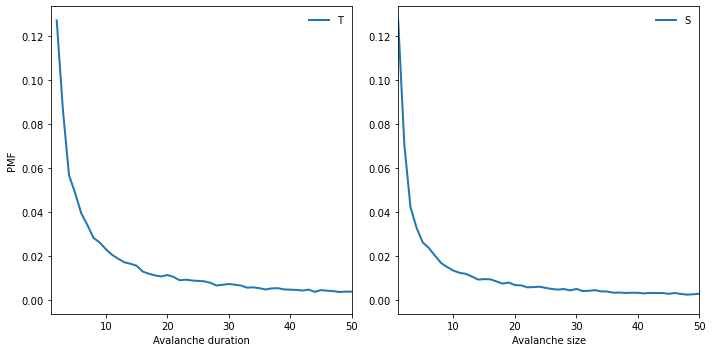

In [21]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

pmfT.plot(label='T')
decorate(xlabel='Avalanche duration',
                 ylabel='PMF',
                 xlim=[1, 50], loc='upper right')

plt.subplot(1, 2, 2)
pmfS.plot(label='S')
decorate(xlabel='Avalanche size',
                 xlim=[1, 50])

savefig('figs/chap08-2')

To see whether these distributions follow a power law, we plot the PMFs on a log-log scale.

[-1.1188474]
[-1.01439469]
Saving figure to file figs/chap08-3


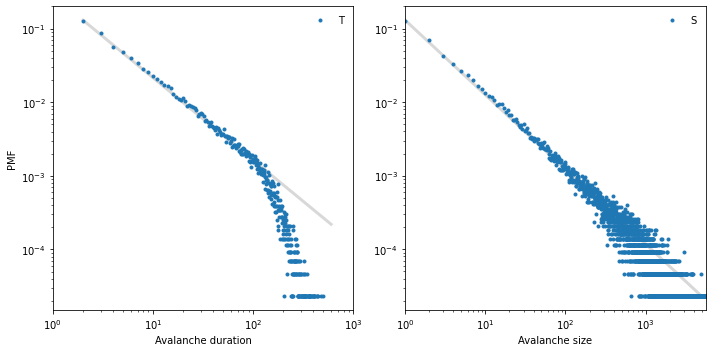

In [22]:
def slope(xs, ys):
    return np.diff(np.log(ys)) / np.diff(np.log(xs))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

xs = [2, 600]
ys = [1.3e-1, 2.2e-4]
print(slope(xs, ys))

options = dict(lw=3, color='gray', alpha=0.3)
plt.plot(xs, ys, **options)

pmfT.plot(lw=0, marker='.', label='T')
decorate(xlabel='Avalanche duration',
                 xlim=[1, 1000],
                 ylabel='PMF',
                 xscale='log',
                 yscale='log',
                 loc='upper right')

plt.subplot(1, 2, 2)

xs = [1, 5000]
ys = [1.3e-1, 2.3e-5]
print(slope(xs, ys))

plt.plot(xs, ys, **options)
pmfS.plot(lw=0, marker='.', label='S')
decorate(xlabel='Avalanche size',
                 xlim=[1, 5600],
                 xscale='log',
                 yscale='log')

savefig('figs/chap08-3')

The gray lines have slopes near -1.  The distribution of avalanche duration is approximately straight between 1 and 100, but then drops off.  The distribution of size follows a power law more closely and over a greater range, but it also seems to drop off for values above a few hundred.

**Exercise:** Try running the model longer to see if you can get a less noisy plot of the distributions of `T` and `S`.

## Fractals

If the sand pile is in a critical state, we expect to see fractal geometry.

To estimate the fractal dimension, I'll start with a bigger pile and a higher initial level.

In [23]:
pile3 = SandPile(n=131, level=22)
%time pile3.run()

CPU times: user 24.7 s, sys: 1.98 ms, total: 24.7 s
Wall time: 24.8 s


(28379, 211320220)

The initial state sure looks like a fractal.

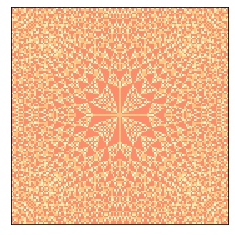

In [24]:
pile3.draw()

Since it contains four different levels (0, 1, 2, and 3), we can extract 4 binary patterns.

In [25]:
def draw_four(pile, levels=range(4)):
    plt.figure(figsize=(8, 8))
    for i, level in enumerate(levels):
        plt.subplot(2, 2, i+1)
        draw_array(pile.array==level, cmap='YlOrRd', vmax=1)
    
    plt.tight_layout()

Here's what they look like:

Saving figure to file figs/chap08-4


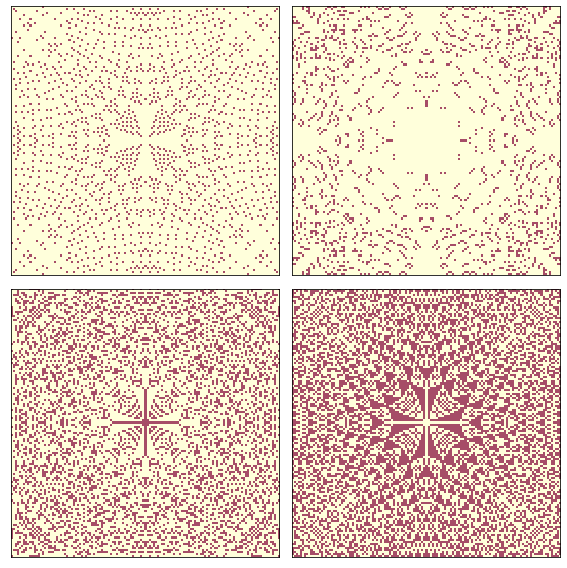

In [26]:
draw_four(pile3)
savefig('figs/chap08-4')

Now we can apply a box-counting algorithm to each level.

`count_cells` starts with a single cell in the middle, gradually increases the size of the box, and counts the number of cells in each box.

In [27]:
def count_cells(a):
    """Counts the number of cells in boxes with increasing size.
    
    a: NumPy array
    
    returns: list of (i, i**2, cell count) tuples
    """
    n, m = a.shape
    end = min(n, m)
    
    res = []
    for i in range(1, end, 2):
        top = (n-i) // 2
        left = (m-i) // 2
        box = a[top:top+i, left:left+i]
        total = np.sum(box)
        res.append((i, i**2, total))
        
    return np.transpose(res)

`box_count` takes a pile and a level, extracts the cells that have the given level, calls `count_cells`, and estimates the fractal dimension.

If `plot` is `True`, it also generates a graph of cell count versus box size on a log-log scale.

In [28]:
from scipy.stats import linregress

def box_count(pile, level, plot=False):
    """Estimates the fractal dimension by box counting.
    
    pile: SandPile
    level: which level from the pile to count
    plot: boolean, whether to generate a plot
    
    returns: estimated fractal dimension
    """
    res = count_cells(pile.array==level)
    steps, steps2, cells = res
    
    # select the range where we have a nonzero number of cells
    legit = np.nonzero(cells)
    steps = steps[legit]
    steps2 = steps2[legit]
    cells = cells[legit]

    if plot:
        # only put labels on the left and bottom subplots
        xlabel = 'Box Size' if level in [2, 3] else ''
        ylabel = 'Cell Count' if level in [0, 2] else ''
    
        options = dict(linestyle='dashed', color='gray', alpha=0.7)
        plt.plot(steps, steps2, **options)
        plt.plot(steps, cells, label='level=%d' % level)
        plt.plot(steps, steps, **options)

        decorate(xscale='log', yscale='log',
                         xlim=[1, 200], loc='upper left',
                         xlabel=xlabel, ylabel=ylabel)
        #thinkplot.bigger_text()

    params = linregress(np.log(steps), np.log(cells))
    return params[0]

Finally `box_count_four` applies the box counting algorithm for each value in the sand pile.

In [29]:
def box_count_four(pile, levels=range(4)):
    """Applies box counting to each level in the pile.
    
    pile: SandPile
    levels: list of levels to check
    """
    plt.figure(figsize=(8, 8))

    dims = []
    for i, level in enumerate(levels):
        plt.subplot(2, 2, i+1)
        dim = box_count(pile, level, plot=True)
        dims.append(dim)
        
    return dims

Here are the results:

Saving figure to file figs/chap08-5


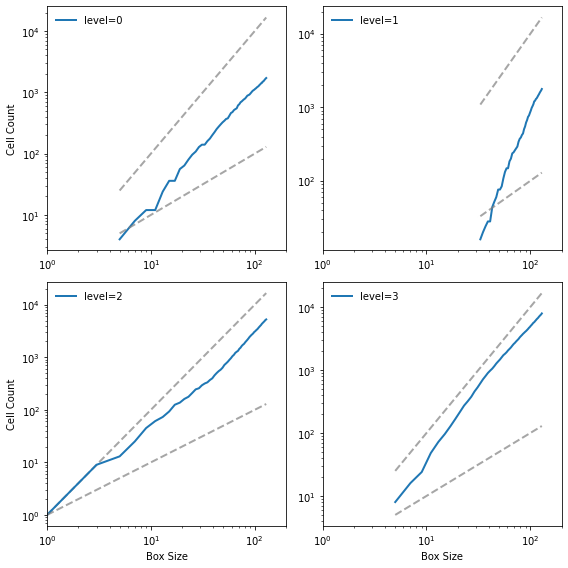

In [30]:
dims = box_count_four(pile3)
savefig('figs/chap08-5')

The lines are reasonably straight, which indicates that we are running the algorithm over a valid range of box sizes.  Here are the estimated slopes:

In [31]:
for i, dim in enumerate(dims):
    print('%d  %0.3f' % (i, dim))

0  1.871
1  3.502
2  1.781
3  2.084


The fractal dimensions for levels 0, 1, and 2 seem to be non-integer, which indicates that the image is fractal.

The fractal dimension for value 3 is indistinguishable from 2, but given the results for the other levels, the apparent curvature of the line, and the appearance of the pattern, it seems likely that it is also fractal. 

**Exercise:**  Choose a different value of `n` and/or the initial `level` and run this analysis again.  Are the estimated fractal dimensions consistent?

CPU times: user 10.1 s, sys: 2.04 ms, total: 10.1 s
Wall time: 10.2 s
0  1.913
1  3.485
2  1.720
3  2.194


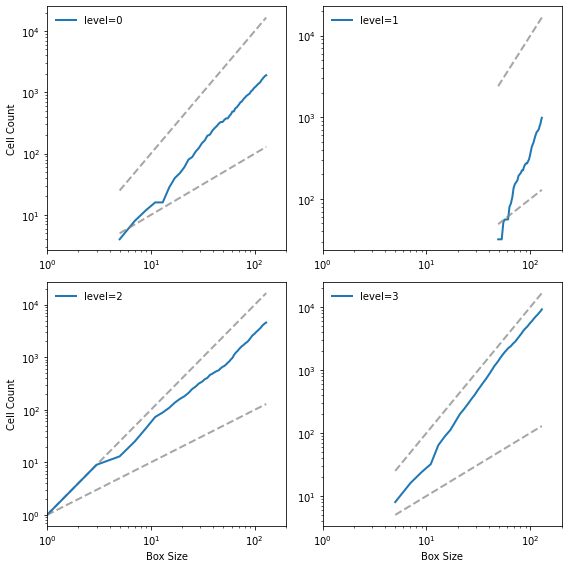

In [33]:
pile3 = SandPile(n=131, level=10)
%time pile3.run()

dims = box_count_four(pile3)

for i, dim in enumerate(dims):
    print('%d  %0.3f' % (i, dim))
    
# They're relatively consistent

## Spectral density

Suppose the sandpile made a little click each time a cell toppled.  What would it sound like?

`toppled_seq` contains the number of cells that toppled during each time step.  We can use Welch's algorithm to estimate its [power spectral density](https://en.wikipedia.org/wiki/Spectral_density).

In [34]:
signal = pile2.toppled_seq
len(signal)

1429764

In [35]:
from scipy.signal import welch

nperseg = 2048
freqs, powers = welch(signal, nperseg=nperseg, fs=nperseg)

And here's what it looks like.

Saving figure to file figs/chap08-6


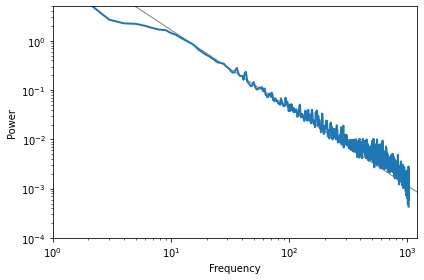

In [36]:
x = nperseg
ys = np.array([x**1.58, 1]) / 2.7e3
plt.plot([1, x], ys, color='gray', linewidth=1)

plt.plot(freqs, powers)
decorate(xlabel='Frequency',
         xscale='log', 
         xlim=[1, 1200],
         ylabel='Power', 
         yscale='log', 
         ylim=[1e-4, 5])

savefig('figs/chap08-6')

The slope of the line is -1.58, which indicates that this spectrum is pink noise with parameter $\beta=1.58$.

**Exercise:**  Choose a different value of `nperseg` and run this analysis again.  What are the pros and cons of larger segment lengths?  Modify the code to run the model longer and see if you can get a less noisy estimate of the spectrum.

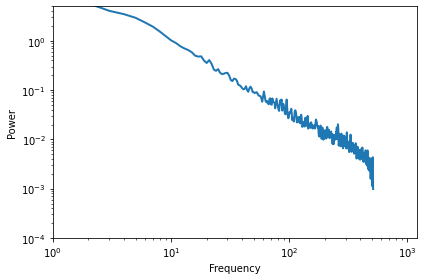

In [38]:
nperseg = 1024
freqs, powers = welch(signal, nperseg=nperseg, fs=nperseg)

x = nperseg
ys = np.array([x**1.58, 1]) / 2.7e3

plt.plot(freqs, powers)
decorate(xlabel='Frequency',
         xscale='log', 
         xlim=[1, 1200],
         ylabel='Power', 
         yscale='log', 
         ylim=[1e-4, 5])

# Using shorter segments means that not as high frequencies can be estimated

## Exercises

**Exercise:** To test whether the distributions of `T` and `S` are heavy-tailed, we plotted their `Pmf` on a log-log scale, which is what Bak, Tang, and Wiesenfeld show in their paper.  But as we saw in Chapter 4, this visualization can obscure the shape of the distribution.  Using the same data, make a plot that shows the CDFs of `S` and `T`.  What can you say about the shape of these distributions?  Do they follow a power law?  Are they heavy tailed?

You might find it helpful to plot the CDFs on a log-x scale and the complementary CDFs on a log-log scale.

**Exercise:** In Section 8.5 we showed that the initial equilibrium of the sand pile model produces fractal patterns.  But after we drop a large number of random grains, the patterns look more random.

Starting with the example in Section 8.5, run the sand pile model for a while and then compute fractal dimensions for each of the 4 levels.  Is the sand pile model fractal in steady state?

**Exercise:** Another version of the sand pile model, called the "single source" model, starts from a different initial condition: instead of all cells at the same level, all cells are set to 0 except the center cell, which is set to a very large value.

Write a function that creates a `SandPile` object, sets up the single source initial condition, and runs until the pile reaches equilibrium.  Does the results appear to be fractal?

You can read more about this version of the sand pile model at http://math.cmu.edu/~wes/sandgallery.html